# Uniform (-1, 1) Cl par. 0.1

In [1]:
import argparse
import os
import numpy as np
import math

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import seaborn as sn
import pandas as pd

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.functional as F
import torch
import shutil
import time

from utils import arg_parser_handler, show, distribution_select, generators_confusion_matrix, plot_confusion_matrix

from models_stk_cifar import Generator, Discriminator

os.makedirs('images_ensemble_mnist10_classifier_small', exist_ok=True)
shutil.rmtree('images_ensemble_mnist10_classifier_small')
os.makedirs('images_ensemble_mnist10_classifier_small', exist_ok=True)

%matplotlib inline

In [2]:
#Inicializa inputs por meio de notebook (variaveis de classe) ou por terminal (argparse)
args, flag = arg_parser_handler().parser_maker()
if flag == 1:
    args.batch_size=64
    args.n_epochs=10
    args.vae_name = None
    args.dim1 = 256
    args.dim2 = 64
    args.n_paths_G = 10
    args.classifier_para=0.1
    print('No args!')
elif flag == 0:
    print(args)

CUDA = True if torch.cuda.is_available() else False
VAE_FOLDER = 'vae_pretrained/'
IMG_SHAPE = (3, 32, 32)
SHARED_CLASSIFIER = True
DISTRIBUTION = 'uniform'


No args!


usage: ipykernel_launcher.py [-h] [--n_epochs N_EPOCHS]
                             [--batch_size BATCH_SIZE] [--lr LR] [--b1 B1]
                             [--b2 B2] [--n_cpu N_CPU]
                             [--latent_dim LATENT_DIM] [--img_size IMG_SIZE]
                             [--channels CHANNELS]
                             [--sample_interval SAMPLE_INTERVAL]
                             [--n_paths_G N_PATHS_G]
                             [--classifier_para CLASSIFIER_PARA]
                             [--vae_name VAE_NAME] [--dim1 DIM1] [--dim2 DIM2]
                             [--min_size_dataset MIN_SIZE_DATASET]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/corsair/.local/share/jupyter/runtime/kernel-42203c45-8626-4aa4-8ca3-9f2866ca9471.json


In [3]:
# Configure data loader
os.makedirs('data/mnist', exist_ok=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar', train=True, download=True,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([.5],[.5],[.5])
                   ])),
    batch_size=args.batch_size, shuffle=True, drop_last=True)

Tensor = torch.cuda.FloatTensor if CUDA else torch.FloatTensor

Files already downloaded and verified


In [4]:
'''a, _ = next(iter(dataloader))
a.shape
gen = Generator().cuda()
z = Variable(Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_dim))))
out_gen = gen.paths[0](z)
out_gen.shape'''

'a, _ = next(iter(dataloader))\na.shape\ngen = Generator().cuda()\nz = Variable(Tensor(np.random.normal(0, 1, (args.batch_size, args.latent_dim))))\nout_gen = gen.paths[0](z)\nout_gen.shape'

In [5]:
'''out_gen.shape
init_tensor = torch.zeros(args.batch_size,3,32,32)
disc = Discriminator(init_sample = init_tensor, n_paths_G=args.n_paths_G).cuda()
out_disc = disc(out_gen)
out_disc[0].shape
out_disc[1].shape
args.n_paths_G'''

'out_gen.shape\ninit_tensor = torch.zeros(args.batch_size,3,32,32)\ndisc = Discriminator(init_sample = init_tensor, n_paths_G=args.n_paths_G).cuda()\nout_disc = disc(out_gen)\nout_disc[0].shape\nout_disc[1].shape\nargs.n_paths_G'

In [6]:
'''out_disc[0].shape
valid = Variable(Tensor(100, 1).fill_(1.0), requires_grad=False)
valid.shape
z = Variable(Tensor(np.random.normal(0, 1, (100, 100))))
gen_imgs = gen.paths[0](z)
validity, classification = disc(gen_imgs)
# Loss measures generator's ability to fool the discriminator
target = Variable(Tensor(100).fill_(1), requires_grad=False)
target = target.type(torch.cuda.LongTensor)
F.nll_loss(classification, target)
adversarial_loss(validity, valid)'''

"out_disc[0].shape\nvalid = Variable(Tensor(100, 1).fill_(1.0), requires_grad=False)\nvalid.shape\nz = Variable(Tensor(np.random.normal(0, 1, (100, 100))))\ngen_imgs = gen.paths[0](z)\nvalidity, classification = disc(gen_imgs)\n# Loss measures generator's ability to fool the discriminator\ntarget = Variable(Tensor(100).fill_(1), requires_grad=False)\ntarget = target.type(torch.cuda.LongTensor)\nF.nll_loss(classification, target)\nadversarial_loss(validity, valid)"

In [7]:
def generators_confusion_matrix(generator, discriminator, num_gens, shape_z, samples = 100):

    generator.eval()
    discriminator.eval()
    acc_all_gens = np.zeros((num_gens, num_gens))
    temp = []

    for s in range(samples):
        z = Variable(Tensor(distribution_select(DISTRIBUTION, shape_z)))
        for k in range(num_gens):

            # Generate a batch of images
            gen_imgs = generator.paths[k](z)

            # Loss measures generator's ability to fool the discriminator

            validity, classification = discriminator(gen_imgs)
            # Loss measures classifier's ability }to classify various generators

            target = Variable(Tensor(shape_z[0]).fill_(k), requires_grad=False)
            target = target.type(torch.cuda.LongTensor)

            acc_gen_k = []

            for target in range(num_gens):
                acc = ((classification.argmax(dim=1))==target).sum().cpu().numpy()/shape_z[0]
                acc_gen_k.append(acc)

            acc_all_gens[k] = (np.array(acc_all_gens[k]) + np.array(acc_gen_k))
            torch.cuda.empty_cache()

    return acc_all_gens/samples

In [8]:
def train_models(dataloader, generator, discriminator,
                 adversarial_loss, optimizer_D, optimizer_G, 
                 classifier = None, optimizer_C = None, show_logs = False):
       
    for epoch in tqdm_notebook(range(args.n_epochs)):

        start = time.time()
        epoch_start = 0
        g_loss_epoch = 0
        d_loss_epoch = 0
        c_loss_1_epoch = 0
        c_loss_2_epoch = 0
        num_batches = len(dataloader)
        generator.train()
        discriminator.train()
        
        for i, (imgs, _) in enumerate(dataloader):

            # Adversarial ground truths
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()
            
            # Sample noise as generator input
            z = Variable(Tensor(distribution_select(DISTRIBUTION, (args.batch_size, args.latent_dim))))

            g_loss = 0
            c_loss_1 = 0
            for k in range(args.n_paths_G):

                # Generate a batch of images
                gen_imgs = generator.paths[k](z)

                # Loss measures generator's ability to fool the discriminator
                
                validity, classification = discriminator(gen_imgs)
                g_loss += adversarial_loss(validity, valid)

                # Loss measures classifier's ability to classify various generators
                
                target = Variable(Tensor(imgs.size(0)).fill_(k), requires_grad=False)
                target = target.type(torch.cuda.LongTensor)
                
                if SHARED_CLASSIFIER == False:
                    classification = classifier(gen_imgs)
                
                c_loss_1 += F.nll_loss(classification, target)*args.classifier_para

            g_loss_epoch += g_loss
            c_loss_1_epoch += c_loss_1

            g_loss = g_loss + c_loss_1
            g_loss.backward()
            optimizer_G.step()

            # ------------------------------------
            #  Train Discriminator and Classifier
            # ------------------------------------

            optimizer_D.zero_grad()
            
            if (SHARED_CLASSIFIER == False): 
                optimizer_C.zero_grad()
            
            d_loss = 0
            c_loss_2 = 0
            
            
            validity, classification = discriminator(real_imgs)
            real_loss = adversarial_loss(validity, valid)
            temp = []
            for k in range(args.n_paths_G):

                # Generate a batch of images
                gen_imgs = generator.paths[k](z).view(imgs.shape[0], *IMG_SHAPE)
                temp.append(gen_imgs[0:20, :])
                  
                
                # Loss measures discriminator's ability to classify real from generated samples
                validity, classification = discriminator(gen_imgs.detach())
                fake_loss = adversarial_loss(validity, fake)
                d_loss += (real_loss + fake_loss) / 2

                # Loss measures classifier's ability to classify various generators
                target = Variable(Tensor(imgs.size(0)).fill_(k), requires_grad=False)
                target = target.type(torch.cuda.LongTensor)
                
                if (SHARED_CLASSIFIER == False):
                    classification = classifier(gen_imgs)
                c_loss_2 += F.nll_loss(classification, target)*args.classifier_para

            plot_imgs = torch.cat(temp, dim=0)

            d_loss_epoch += d_loss
            c_loss_2_epoch += c_loss_2
            

            d_loss = d_loss + c_loss_2
            d_loss.backward()
            optimizer_D.step()
                
            batches_done = epoch * len(dataloader) + i

        interval = time.time() - start

        if epoch % (args.n_epochs//5) == 0 and show_logs:

            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss 1: %f] [C loss 2: %f] \t Time Interv: %f"
                   % (epoch, args.n_epochs, i, num_batches, d_loss_epoch.item()/num_batches, g_loss_epoch.item()/num_batches, 
                      c_loss_1_epoch.item()/num_batches, c_loss_2_epoch.item()/num_batches, interval))

            show(make_grid(plot_imgs.cpu(), nrow=20, normalize=True), 20)
            conf_matrix = generators_confusion_matrix(generator, discriminator, num_gens=args.n_paths_G, 
                                        shape_z=(args.batch_size, args.latent_dim))
            plot_confusion_matrix(conf_matrix)
            plt.show()

In [9]:
init_tensor = torch.zeros(args.batch_size,3,32,32)

Total Units : 4608


/home/corsair/.conda/envs/torch_gan/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


[Epoch 0/10] [Batch 780/781] [D loss: 1.754495] [G loss: 39.080566] [C loss 1: 0.016988] [C loss 2: 0.018142] 	 Time Interv: 302.678020


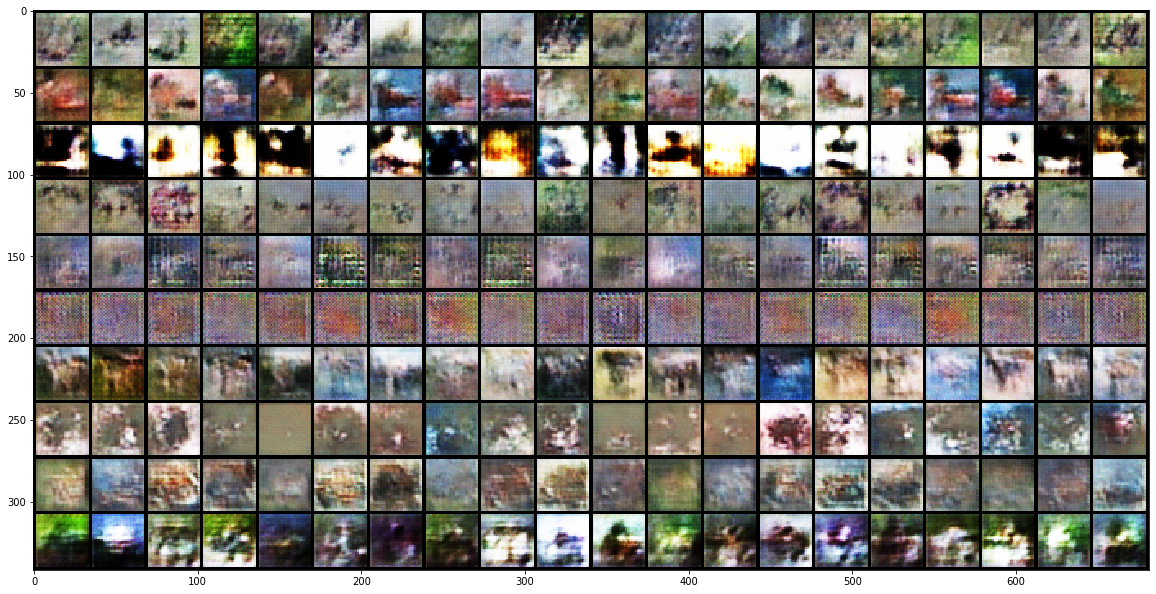

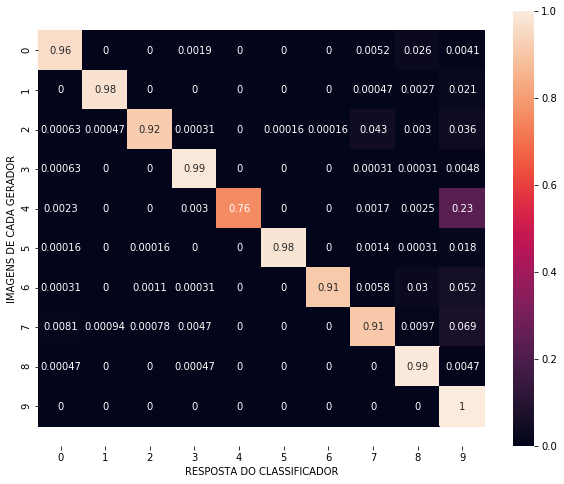

In [ ]:
branch_counter = 0
gen_stack= []
disc_stack =[]
data_loader_stack = []

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

generator = Generator(n_paths_G=args.n_paths_G)  
discriminator = Discriminator(n_paths_G=args.n_paths_G, init_sample=init_tensor)
        
if CUDA:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=args.lr, betas=(args.b1, args.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=args.lr, betas=(args.b1, args.b2))

train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)



In [ ]:
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)



In [ ]:
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)



In [ ]:
train_models(dataloader, generator, discriminator, adversarial_loss, 
             optimizer_D, optimizer_G, show_logs=True)


In [ ]:
3